Clustering and classification for features extracted from tiles modified with Macenko's method without masking with HistomicsTK.

---
# 0. - Imports and paths

In [2]:
import os
import pandas as pd
import matplotlib.font_manager as fm
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from PIL import Image, ImageDraw
import numpy as np
import re
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import PCA#, TruncatedSVD
#import umap
import umap.umap_ as umap
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D

/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.chdir("/disk2/user/gabgam/work/gigi_env/the_project/4_clustering_and_classification/")
print(os.getcwd())

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification


In [4]:
# Fetch DM Sans font file from https://github.com/google/fonts/blob/main/ofl/dmsans/DMSans%5Bopsz%2Cwght%5D.ttf or, better, https://fonts.google.com/specimen/DM+Sans
font_path = "../fonts/static/DMSans-Medium.ttf" 

# Add font to matplotlib
try:
    fm.fontManager.addfont(font_path)
    plt.rcParams['font.family'] = 'DM Sans'
except RuntimeError as e:
    print(f"Failed to load font: {e}")

In [5]:
model = "kimianet"

In [6]:
# WIDTH = 1000
# PATH_TO_MERGED_PICKLES = f"output/{model}/satac_C1_v3_allspots_&_visium_2022_FF_WG_10X_img_not_changed_allspots/"
# COMPARISON = "satac_C1_v3_allspots_&_visium_2022_FF_WG_10X_img_not_changed_allspots"

# if WIDTH:
#     SELECTED_PICKLE_100um = f'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_histomicsTK_macenko_nomasking_width{WIDTH}.pickle'
#     SELECTED_PICKLE_68um = f'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_histomicsTK_macenko_nomasking_width{WIDTH}.pickle'
# else:
#     SELECTED_PICKLE_100um = 'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_histomicsTK_macenko_nomasking.pickle'
#     SELECTED_PICKLE_68um = 'MERGED_satac_C1_&_v3_allspots__&__visium_2022_FF_WG_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_histomicsTK_macenko_nomasking.pickle'

In [7]:
WIDTH = 1000
PATH_TO_MERGED_PICKLES = f"output/{model}/satac_C1_v3_allspots_&_visium_FFPE_dcis_idc_10X_img_not_changed_allspots/"
COMPARISON = "satac_C1_v3_allspots_&_visium_FFPE_dcis_idc_10X_img_not_changed_allspots"

if WIDTH:
    SELECTED_PICKLE_100um = f'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_histomicsTK_macenko_nomasking_width{WIDTH}.pickle'
    SELECTED_PICKLE_68um = f'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_histomicsTK_macenko_nomasking_width{WIDTH}.pickle'
else:
    SELECTED_PICKLE_100um = 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_histomicsTK_macenko_nomasking.pickle'
    SELECTED_PICKLE_68um = 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_histomicsTK_macenko_nomasking.pickle'

In [8]:
# path to the target image
PATH_TO_REFERENCE = "../2_image_normalisation/reference_images/reference_full.jpeg"
# `TARGET_IS_<filename>`
TARGET_IS = "target_is_reference_full"

Defining the path to the figures.

In [9]:
if WIDTH:
    PATH_TO_FIGURES = f"figures/{model}/{COMPARISON}_width{WIDTH}"
else:
    PATH_TO_FIGURES = f"figures/{model}/{COMPARISON}"
    
os.makedirs(PATH_TO_FIGURES, exist_ok=True)

# 1. - Importing the extracted features

First of all, let's see all the MERGED `.pickle` files inside the folder of the saved features.

In [10]:
if WIDTH:
    all_pickle_names = [i for i in os.listdir(PATH_TO_MERGED_PICKLES) if i.endswith(f'{WIDTH}.pickle')]
else:
    all_pickle_names = [i for i in os.listdir(PATH_TO_MERGED_PICKLES) if i.endswith('.pickle')]

print(f"{len(all_pickle_names)} .pickle files inside the folder.\n")
print(all_pickle_names)

8 .pickle files inside the folder.

['MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_ORIGINAL WSI_width1000.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_fromWSI_histomicsTK_macenko_nomasking_width1000.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_histomicsTK_macenko_nomasking_width1000.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_100um_stainNET_width1000.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_ORIGINAL WSI_width1000.pickle', 'MERGED_satac_C1_&_v3_allspots__&__visium_FFPE_dcis_idc_10X_&_img_not_changed_allspots__for__target_is_reference_full_68um_fromWSI_histomicsTK_mac

And let's choose the first file to visualise and extract the normalisation name from it.

In [11]:
TILE_SIZE = 100
SPOT_SIZE = 68

# Extractin the normalisation name from just one of it. They are the same in the end
# Find the pattern matching "<number>um_", the normalisation name is after it.
match = re.search(r"\d+um_", SELECTED_PICKLE_100um)

if match:
    # Extract everything after "<number>um_", remove the file type name and replace eventually present underscores with spaces.
    normalisation_name = SELECTED_PICKLE_100um.split(match.group())[-1].split(".")[0].replace("_", " ")
else:
    print("Wrong file inserted, no normalisation name found.")

print(normalisation_name)

histomicsTK macenko nomasking width1000


In [12]:
from utils_clust_n_class import load_pickle_as_df

merged_selected_pickle_df_100um = load_pickle_as_df(os.path.join(PATH_TO_MERGED_PICKLES, SELECTED_PICKLE_100um))
merged_selected_pickle_df_100um

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
TTATTTCCAGTATCTT_row6_col18_100um_histomicsTK_macenko_nomasking,0.084122,0.107487,0.026008,-0.271490,0.235142,1.924299,0.074862,0.159275,-0.419862,-0.041799,...,-0.046560,1.912279,0.573348,0.194324,-0.522523,0.756258,1.644386,0.522864,1.477387,0.121405
TCAAATCACCATTGTT_row7_col19_100um_histomicsTK_macenko_nomasking,0.080582,0.096211,0.037149,-0.240635,0.250871,1.887596,0.074137,0.158743,-0.417766,-0.049032,...,0.195669,1.695265,0.646225,0.373662,-0.126699,1.040185,1.515065,0.533572,1.109231,0.644456
CTGTAAGTCTTCTGCT_row6_col20_100um_histomicsTK_macenko_nomasking,0.086917,0.102518,0.019652,-0.271130,0.217888,2.339349,0.073441,0.159151,-0.497960,-0.039970,...,-0.210836,1.860708,0.778186,-0.196565,-0.435681,0.869932,1.056139,0.015275,0.972724,0.087262
ACATCCGACTTTGGGT_row7_col21_100um_histomicsTK_macenko_nomasking,0.082817,0.116164,0.051966,-0.291666,0.209503,1.635359,0.072009,0.157860,-0.484246,-0.063128,...,-0.067768,1.898356,0.505435,-0.084244,-0.544379,0.819805,1.421008,0.176168,1.266020,0.293986
TGATAGATGCCCTGTT_row6_col22_100um_histomicsTK_macenko_nomasking,0.086880,0.124773,0.052340,-0.373984,0.236924,0.977893,0.076168,0.158705,-0.506613,-0.084515,...,0.069376,2.293530,0.232118,-0.036627,-0.413889,0.767555,0.976645,-0.397515,1.970001,-0.795448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCCCTGAGGATGGGCT-1_row68_col74_100um_histomicsTK_macenko_nomasking,0.087164,0.157941,0.148354,-0.342810,0.246926,-0.037724,0.044969,0.162607,-0.907903,-0.177052,...,-0.595300,1.822055,0.110980,-3.082780,-1.701675,2.873890,1.604071,0.348344,1.784855,-0.545100
CGGGCGATGGATCACG-1_row69_col75_100um_histomicsTK_macenko_nomasking,0.079936,0.140664,0.136015,-0.424146,0.386888,-0.521980,0.044552,0.160865,-0.483319,-0.137408,...,0.566210,1.965824,0.356818,-2.273687,-1.723016,1.966209,1.630068,0.611301,1.490819,0.464393
TGCGGACTTGACTCCG-1_row68_col76_100um_histomicsTK_macenko_nomasking,0.103198,0.162658,0.133750,-0.291215,0.198435,0.355201,0.051257,0.166313,-0.982973,-0.202299,...,-0.492814,1.456977,0.168371,-2.782088,-1.701663,2.411969,1.571803,0.331912,1.350032,-0.506060
TCGCTGCCAATGCTGT-1_row68_col80_100um_histomicsTK_macenko_nomasking,0.097312,0.150152,0.124950,-0.386572,0.297204,-0.493912,0.043898,0.164982,-0.693635,-0.181372,...,0.603122,2.262336,-0.082044,-3.329694,-2.329334,2.311185,1.745681,0.820264,1.847851,0.203214


In [13]:
from utils_clust_n_class import load_pickle_as_df

merged_selected_pickle_df_68um = load_pickle_as_df(os.path.join(PATH_TO_MERGED_PICKLES, SELECTED_PICKLE_68um))
merged_selected_pickle_df_68um

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
CCGACCACCCTACGCG_row0_col0_68um_histomicsTK_macenko_nomasking,0.090870,0.088246,0.050341,-0.253982,0.231544,2.633037,0.072878,0.160640,-0.404131,-0.038658,...,0.255939,1.888256,1.236099,0.583504,-0.254938,0.606776,1.303118,1.177569,1.625504,0.527789
AAGCCATAGTCGCGAC_row1_col1_68um_histomicsTK_macenko_nomasking,0.091428,0.096527,0.027292,-0.280739,0.237860,1.941168,0.075486,0.160763,-0.454993,-0.038165,...,0.448402,1.427363,1.287786,0.387704,-0.373563,0.665116,1.923006,0.928795,1.450498,1.027646
TTGGGCGGACCGAAGC_row0_col2_68um_histomicsTK_macenko_nomasking,0.095827,0.074349,0.018420,-0.264149,0.184443,2.355540,0.077238,0.161798,-0.438112,-0.009033,...,0.262958,1.637545,1.319618,0.261498,-0.235691,0.501510,1.652467,0.516810,1.435819,0.514481
AGTAAAGCGCATAATC_row1_col3_68um_histomicsTK_macenko_nomasking,0.090650,0.096844,0.026442,-0.257066,0.190419,2.456209,0.071564,0.159953,-0.310068,-0.028257,...,0.201706,1.665944,1.071480,0.472315,-0.223009,0.496271,1.909130,1.395896,1.510821,0.752634
CGACTCCGCCGATCAA_row0_col4_68um_histomicsTK_macenko_nomasking,0.090239,0.097535,0.013634,-0.245306,0.211835,2.640605,0.072238,0.160121,-0.391185,-0.014748,...,0.234849,1.718927,1.201277,0.264613,-0.465634,0.505266,1.565402,0.904106,1.327777,0.632048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCCCTGAGGATGGGCT-1_row68_col74_68um_histomicsTK_macenko_nomasking,0.067309,0.143323,0.131744,-0.386909,0.280551,0.347327,0.042260,0.163563,-0.797706,-0.146835,...,-0.273509,0.871450,1.532667,-0.429881,-0.855962,1.390931,0.703276,-0.173216,1.205389,0.705062
CGGGCGATGGATCACG-1_row69_col75_68um_histomicsTK_macenko_nomasking,0.060710,0.149230,0.104691,-0.432123,0.308605,0.169666,0.049445,0.163539,-0.705157,-0.132437,...,-0.061775,1.105968,1.366938,-1.083201,-1.499051,1.285348,1.005898,-0.312284,1.490233,0.624622
TGCGGACTTGACTCCG-1_row68_col76_68um_histomicsTK_macenko_nomasking,0.082936,0.154327,0.105164,-0.327656,0.187459,0.895445,0.054239,0.165763,-1.023125,-0.169463,...,-0.586350,0.503297,1.524700,-0.738622,-1.371623,1.210303,1.029222,-0.027981,1.499056,0.643716
TCGCTGCCAATGCTGT-1_row68_col80_68um_histomicsTK_macenko_nomasking,0.076488,0.149176,0.115751,-0.404551,0.238851,0.096556,0.048171,0.167569,-0.849125,-0.155301,...,-0.293628,0.976945,1.377934,-1.523002,-1.695989,1.428239,0.928411,-0.472725,1.588694,0.625649


# 2. - Dimensionality reduction

Let's plot the cumulative variance explained by the most important components.

## 2.1 - For 100 μm tiles

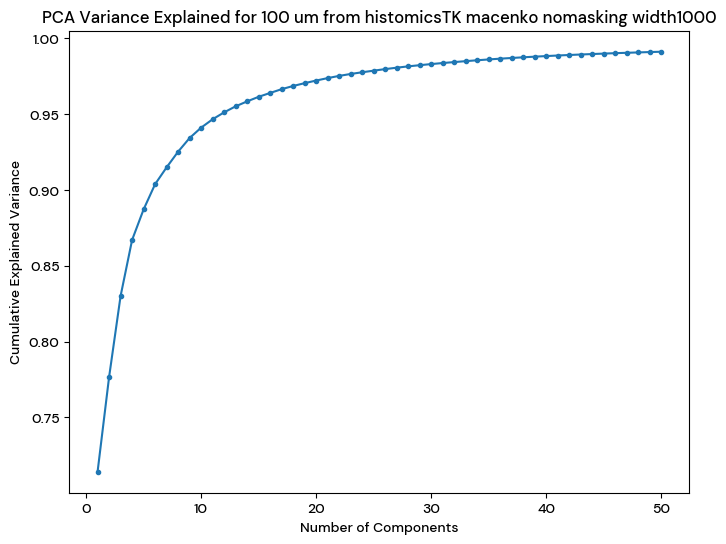

In [14]:
from utils_clust_n_class import pca_cumulative_variance_plot

plot = pca_cumulative_variance_plot(merged_selected_pickle_df_100um, normalisation_name, TILE_SIZE)
plot.show()

Then let's have a quick visualisation of the PCA, UMAP and tSNE plots.

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite'

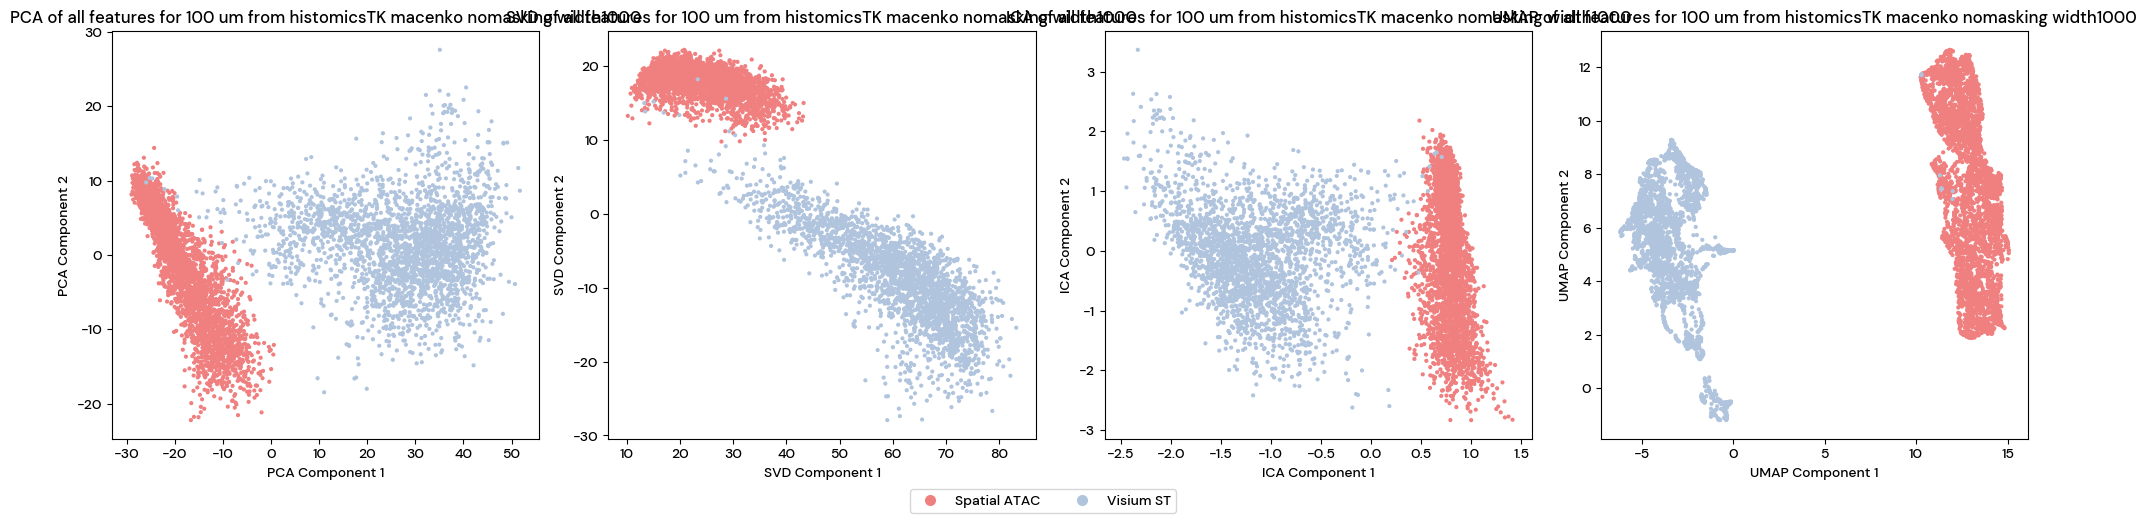

In [15]:
from utils_clust_n_class import all_dim_red

COLORS_FOR_SPATIALS = {"Spatial ATAC": "lightcoral", "Visium ST": "lightsteelblue"}

plot_100, dim_red_results_100 =  all_dim_red(merged_selected_pickle_df_100um, normalisation_name, COLORS_FOR_SPATIALS, TILE_SIZE, selected_methods = ["PCA", "SVD", "ICA", "UMAP"])
plot_100.show()

In [16]:
plot_100.savefig(os.path.join(PATH_TO_FIGURES, f"plot_all_dimensionality_reductions_{TILE_SIZE}um_{normalisation_name.replace(' ', '_')}.pdf"),
                format="PDF", bbox_inches='tight')

So, we can say that the normalisation is necessary.

---

## 2.2 - For 68 μm tiles

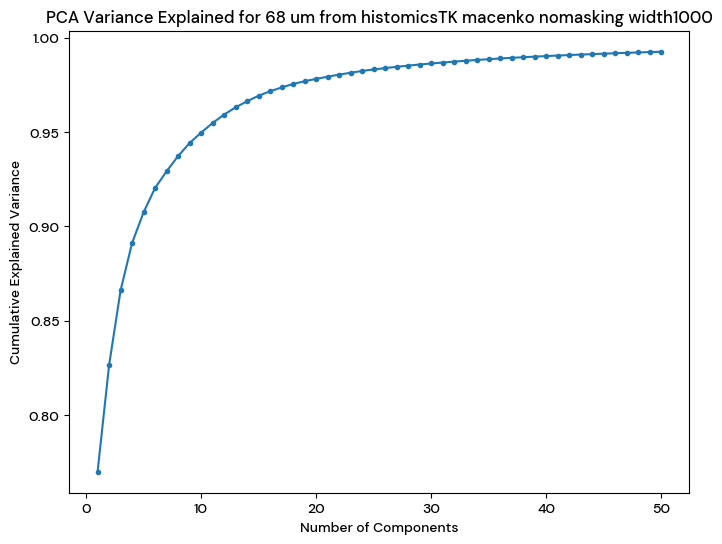

In [17]:
from utils_clust_n_class import pca_cumulative_variance_plot

plot = pca_cumulative_variance_plot(merged_selected_pickle_df_68um, normalisation_name, SPOT_SIZE)
plot.show()

Then let's have a quick visualisation of the PCA, UMAP and tSNE plots.

/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/work/gabgam/gigi_env/the_project/4_clustering_and_classification/utils_clust_n_class.py:159: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(result[:, 0], result[:, 1], c=colors, s=4, cmap='coolwarm')
/disk2/user/gabgam/miniconda3/envs/cluster_n_class/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite'

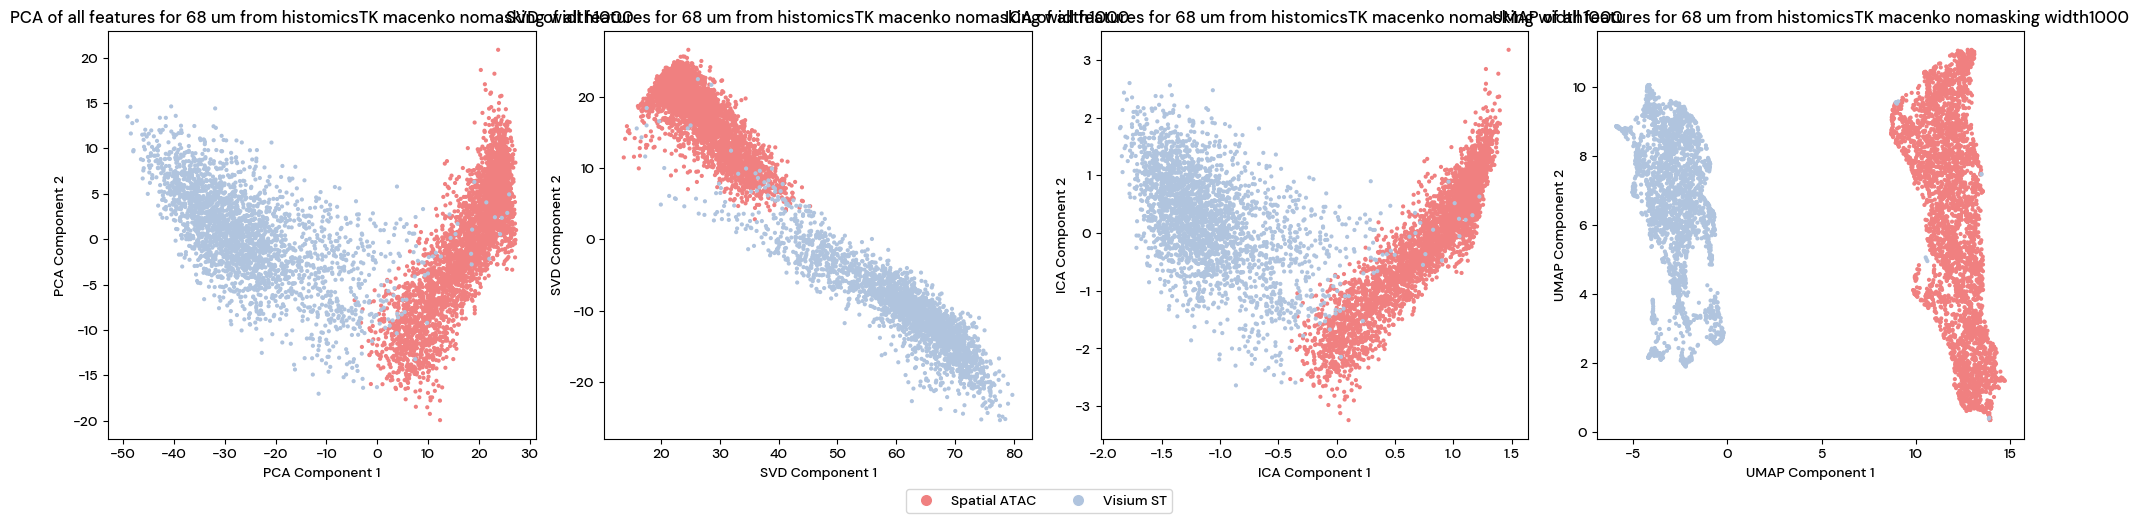

In [18]:
from utils_clust_n_class import all_dim_red

COLORS_FOR_SPATIALS = {"Spatial ATAC": "lightcoral", "Visium ST": "lightsteelblue"}

plot_68, dim_red_results_68 =  all_dim_red(merged_selected_pickle_df_68um, normalisation_name, COLORS_FOR_SPATIALS, SPOT_SIZE, selected_methods = ["PCA", "SVD", "ICA", "UMAP"])
plot_68.show()

In [19]:
plot_68.savefig(os.path.join(PATH_TO_FIGURES, f"plot_all_dimensionality_reductions_{SPOT_SIZE}um_{normalisation_name.replace(' ', '_')}.pdf"), 
                format="PDF", bbox_inches='tight')

So, we can say that the normalisation is necessary.

---